<a href="https://colab.research.google.com/github/carloshernangarrido/kalmanfilters/blob/main/kalman_filter_const_curv_damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman filter for smoothing beam displacements designed by assuming a model of constant curvature which can deviates due to damage

# Packages and modules

In [184]:
%reset-f
# Packages installation
!pip install filterpy

In [185]:
# Modules import
from filterpy.kalman import KalmanFilter # based on the book Kalman_and_Bayesian_Filters_in_Python.pdf
import numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Input parameters

## Classes

In [186]:
class InputParameters: 
  '''
  Description
  ----------
  An object of Input Parameters for a Kalman Filter.

  Atributes
  ----------
  dim_x : int
    State vector dimension. The default state vector 
    dimension is 3, i.e. x_1 = position, x_2 = slope, and x_3 = curvature.
  dim_z : int
    Meassurement vector dimension. The default meassurement 
    vector dimension is 1, i.e. z = position.
  x_init : ndarray(dim_x, 1)
    Initial state
  dx : float
    Step size (Delta t)
  n_steps : int
    Number of steps used for batch filtering.
  r : float
    Meassurement noise as standard deviation, asuming only position is 
    meassured.
  q : float
    Curvature disturbances as standard deviation, assuming only curvature is 
    disturbed. Q_process_noise_var has more priority than q.
  h_d : int
    Radius of apparent damage extent (in points).
  L_d : int
    Apparent length of damage (in points).
  L_ch : int
    Characteristic length of damage (in points).
  H_EI_typ : float
    Typical damage measured as a ratio between damaged stiffness and healthy 
    stiffness. That is H_EI_typ = 0.5 # (EI_d / EI_h) = (curv_h / curv_d)
  ntdc : float
    Normalized typical deviation of curvature due to damage, calculated as
    ntdc = (1/ip.H_EI_typ) - 1# (curv_d - curv_h)/curv_h.
  Q_process_noise_var : float
    process noise variance used to calculate Q from F. This parameter has more 
    priority than q. For using q, left Q_process_noise_var=None.
  F : ndarray(dim_x, dim_x)
    State transition matrix. By default, it assumes constant slope and that 
    the next position is the current position plus current slope times dx
  H : ndarray(dim_z, dim_x)
    Meassurement function. By default, it assumes that only the position is 
    meassured.
  P : ndarray(dim_x, dim_x)
    Covariance matrix describing the uncertainty in the state vector due to 
    disturbances that excite the system. By default it is assumed that position 
    cannot change suddenly but velocity can change during a time step with a 
    variance of std**2.
  R : ndarray(dim_z, dim_z)
    Covariance matrix describing the measurement noise. If only position is 
    meassured, it can be set as a scalar. By default, it assumes a variance of \
    1 for the noise in the position meassurement std**2.
  Q : ndarray(dim_x, dim_x)
    Variance matrix describing the process noise.
  Qs : list(n_steps)
    List of self.n_steps matrices as Q.
  
  Returns
  ----------
  object
    The Input Parameters for a Kalman Filter.  
  '''
    
  def __init__(self, dim_x=3, dim_z=1, x_init=np.array([[0.], [0.], [0.]]),\
               dx=.1, n_steps=None, h_d=None, H_EI_typ=None, r=None, q=None, \
               F=None, H=np.array([[1., 0., 0.]]), P=None, R=None, Q=None, \
               Q_process_noise_var=None):
    self.dim_x = dim_x
    self.dim_z = dim_z
    if x_init.shape == (dim_x,1):
      self.x_init = x_init
    else:
      raise Exception("Initial state must have the same dimension as the state")
    self.dx = dx

    self.n_steps = n_steps

    self.h_d = h_d
    self.L_d = 2*self.h_d    
    self.L_ch = 3*self.L_d
    self.H_EI_typ = H_EI_typ
    self.ntdc = (1/self.H_EI_typ) - 1 # (curv_d - curv_h)/curv_h
    
    if F is None:
      if dx is not None:
        self.F = np.array([[1., self.dx, 0.5*(self.dx**2)], 
                           [0., 1.,      self.dx],
                           [0., 0.,      1.]]) 
      else:
        raise Exception("If State transition matrix F is not defined, step size\
dx must be defined.")
    else:
      self.F = F

    self.H = H

    if R is None:
      if r is None:
        raise Exception("If meassurement noise covariance matrix R is not  \
defined, meassurement noise standard deviation in position r must be defined.")
      else:
        R=np.array([[r**2]])
        self.R = R
    else:
      self.R = R

    if P is None:
      self.P = 1000*np.array([[R[0,0],  0.,               0.], 
                              [0.,      R[0,0]/(dx**2),   0.],
                              [0.,      0.,               R[0,0]/(dx**4)]])
    else:
      self.P = P
            
    if Q is None:
      if Q_process_noise_var is None:
        if q is None:
          raise Exception("If process noise covariance matrix is not defined, \
and process noise variance Q_process_noise_var is not defined, disturbance \
standard deviation q must be defined.")
        else:
          self.q = q
          self.Q = np.array([[0, 0, 0], [0, 0, 0], [0, 0, (self.q)**2]])
      else:
        from filterpy.common import Q_discrete_white_noise
        self.Q_process_noise_var = Q_process_noise_var
        self.Q = Q_discrete_white_noise(dim=dim_x, dt=dx, var=self.Q_process_noise_var)
    else:
      self.Q = Q
    
    if self.n_steps is None:
      self.Qs = []
    else:
      self.Qs = [self.Q] * self.n_steps

class Modal:
  '''
  Description
  ----------
  An object of mode shape.

  Parameters
  ----------
  S : dict
    dictionary returned by scipy.io.loadmat(input_file_name)
    
  Returns
  ----------
  object
    The mode shape.  
  '''  
  def __init__(self, S):
      self.freq = np.array(S['modal']['freq'][0], dtype=np.float64)
      self.x = np.array(S['modal']['x'][0][0], dtype=np.float64)
      self.mode = np.array(S['modal']['mode'][0][0], dtype=np.float64)

## Load input file

In [187]:
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field structural'

input_file_name = os.path.join(path, '13_10_11_run1_modal.mat')

S = scipy.io.loadmat(input_file_name)
modal = Modal(S)

In [188]:
pos_init   = modal.mode[0]
slope_init = (modal.mode[len(modal.x) // 2]-modal.mode[0])/ \
             ((len(modal.x)//2)*np.mean(np.diff(modal.x, axis=0)))
curv_init = (modal.mode[len(modal.x) // 2] - 2*modal.mode[len(modal.x) //4] + modal.mode[0])/ \
             (((len(modal.x)//4)*np.mean(np.diff(modal.x, axis=0)))**2)             
ip = InputParameters(dx=np.mean(np.diff(modal.x, axis=0)), 
                     n_steps=len(modal.x),
                     h_d=3, # apparent length of damage
                     H_EI_typ=0.5, # typical damage
                     r=.002,
                     q=1e-5,
                     x_init=np.array([pos_init, slope_init, curv_init]).reshape(3,1))


# Process

## Previous data

In [189]:
X_vector = modal.x.T
z_vector = modal.mode.T

zs = z_vector.reshape((-1,))
s_vector = np.diff(z_vector, append=0, axis=1)/ip.dx
s_vector[0,-1] = s_vector[0,-2]
c_vector = np.diff(s_vector, prepend=0, axis=1)/ip.dx
c_vector[0,0] = c_vector[0,1]
c_vector_median = scipy.ndimage.median_filter(c_vector, size=ip.L_ch, mode='mirror')


## Filter definition

In [190]:
## Classical Rauch, Tung, and Striebel
# First, construct the object with the required dimensionality.
fk = KalmanFilter(dim_x=ip.dim_x, dim_z=ip.dim_z)
# Set initial state
# Define the state transition matrix
# Define the measurement function
# Define the covariance matrix that describes the disturbance in the state
# Define the covariance matrix that describes the noise in meassurement 
# Assign the process noise.
ip.Q[2,2] = (ip.ntdc*np.max(c_vector_median[0,:]))**2
fk.x, fk.F, fk.H, fk.P, fk.R, fk.Q = \
ip.x_init, ip.F, ip.H, ip.P, ip.R, ip.Q


## Adaptive Rauch, Tung, and Striebel
# First, construct the object with the required dimensionality.
fk_adapt = KalmanFilter(dim_x=ip.dim_x, dim_z=ip.dim_z)
# Set initial state
# Define the state transition matrix
# Define the measurement function
# Define the covariance matrix that describes the disturbance in the state
# Define the covariance matrix that describes the noise in meassurement 
# Assign the process noise.

# Construct ip.Qs as a list
for i, (median_value) in enumerate(c_vector_median[0,:]):
  Q = ip.Q.copy()
  Q[2,2] = (ip.ntdc*median_value)**2
  ip.Qs[i] = Q.copy()

fk_adapt.x, fk_adapt.F, fk_adapt.H, fk_adapt.P, fk_adapt.R, fk_adapt.Q = \
ip.x_init, ip.F, ip.H, ip.P, ip.R, ip.Q

## Filter running

In [191]:
## Classical Rauch, Tung, and Striebel
mu, cov, _, _ = fk.batch_filter(zs)
M, P, C, _ = fk.rts_smoother(mu, cov)
x_vector = mu.T.reshape((3,-1))
z_vector_filt = x_vector[0,:].reshape((1,-1))
s_vector_filt = x_vector[1,:].reshape((1,-1))
c_vector_filt = x_vector[2,:].reshape((1,-1))
x_vector_rts = M.T.reshape((3,-1))
z_vector_filt_rts = x_vector_rts[0,:].reshape((1,-1))
s_vector_filt_rts = x_vector_rts[1,:].reshape((1,-1))
c_vector_filt_rts = x_vector_rts[2,:].reshape((1,-1))


## Adaptive Rauch, Tung, and Striebel
mu_adapt, cov_adapt, _, _ = fk_adapt.batch_filter(zs=zs, Qs=ip.Qs)
M_adapt, P_adapt, C_adapt, _ = fk_adapt.rts_smoother(mu_adapt, cov_adapt)
x_vector_adapt = mu_adapt.T.reshape((3,-1))
z_vector_filt_adapt = x_vector_adapt[0,:].reshape((1,-1))
s_vector_filt_adapt = x_vector_adapt[1,:].reshape((1,-1))
c_vector_filt_adapt = x_vector_adapt[2,:].reshape((1,-1))
x_vector_rts_adapt = M_adapt.T.reshape((3,-1))
z_vector_filt_rts_adapt = x_vector_rts_adapt[0,:].reshape((1,-1))
s_vector_filt_rts_adapt = x_vector_rts_adapt[1,:].reshape((1,-1))
c_vector_filt_rts_adapt = x_vector_rts_adapt[2,:].reshape((1,-1))



# Plots

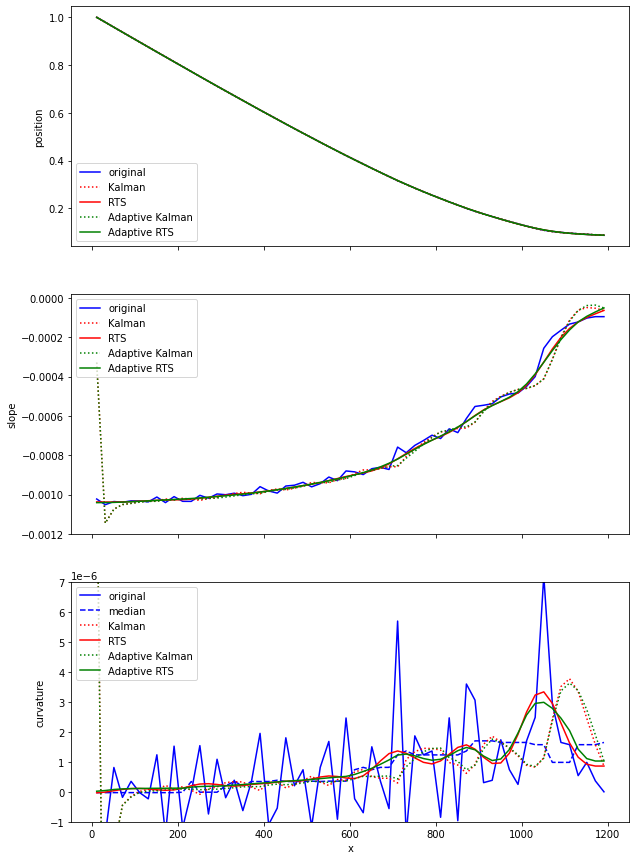

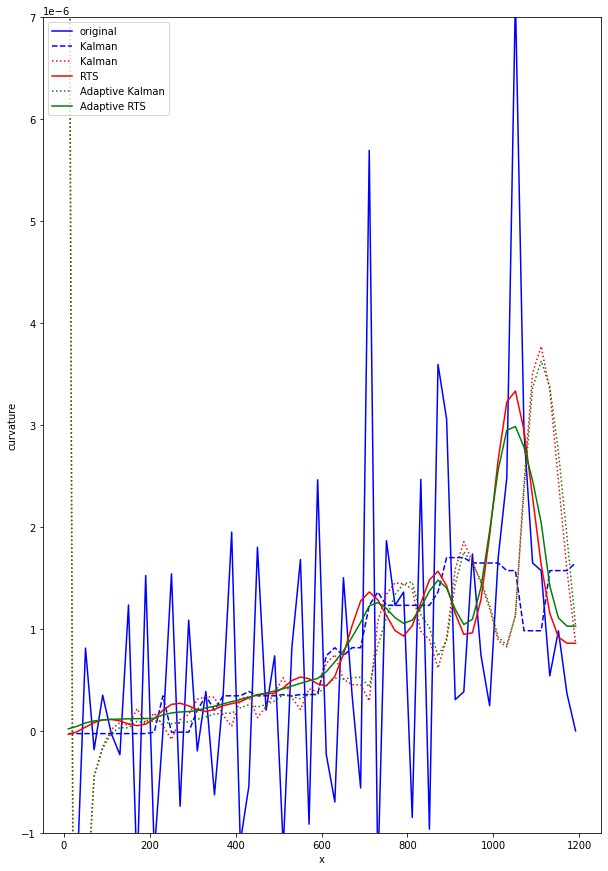

In [192]:
fig_size = (10,15)

fig, ax = plt.subplots(3,1,sharex=True,figsize=fig_size)
row = 0
ax[row].plot(X_vector.T, z_vector.T, color="blue", label="original")
ax[row].plot(X_vector.T, z_vector_filt.T, color ="red", linestyle=':', label="Kalman")
ax[row].plot(X_vector.T, z_vector_filt_rts.T, color="red", label="RTS")
ax[row].plot(X_vector.T, z_vector_filt_adapt.T, color ="green", linestyle=':', label="Adaptive Kalman")
ax[row].plot(X_vector.T, z_vector_filt_rts_adapt.T, color="green", label="Adaptive RTS")
# plt.title("Line graph")
ax[row].set_ylabel("position")
ax[row].legend(loc="lower left")

row = 1
ax[row].plot(X_vector.T, s_vector.T, color="blue", label="original")
ax[row].plot(X_vector.T, s_vector_filt.T, color ="red", linestyle=':', label="Kalman")
ax[row].plot(X_vector.T, s_vector_filt_rts.T, color="red", label="RTS")
ax[row].plot(X_vector.T, s_vector_filt_adapt.T, color ="green", linestyle=':', label="Adaptive Kalman")
ax[row].plot(X_vector.T, s_vector_filt_rts_adapt.T, color="green", label="Adaptive RTS")
# plt.title("Line graph")
ax[row].set_ylabel("slope")
ax[row].legend(loc="upper left")

row = 2
ax[row].plot(X_vector.T, c_vector.T, color="blue", label="original")
ax[row].plot(X_vector.T, c_vector_median.T, color="blue", linestyle='--', label="median")
ax[row].plot(X_vector.T, c_vector_filt.T, color ="red", linestyle=':', label="Kalman")
ax[row].plot(X_vector.T, c_vector_filt_rts.T, color="red", label="RTS")
ax[row].plot(X_vector.T, c_vector_filt_adapt.T, color ="green", linestyle=':', label="Adaptive Kalman")
ax[row].plot(X_vector.T, c_vector_filt_rts_adapt.T, color="green", label="Adaptive RTS")
ax[row].set_ylim(-1e-6, 7e-6)
# plt.title("Line graph")
ax[row].set_xlabel("x")
ax[row].set_ylabel("curvature")
ax[row].legend(loc="upper left")
plt.show()


fig_curv = plt.figure(figsize=fig_size)
plt.plot(X_vector.T, c_vector.T, color="blue", label="original")
plt.plot(X_vector.T, c_vector_median.T, color="blue", linestyle='--', label="Kalman")
plt.plot(X_vector.T, c_vector_filt.T, color ="red", linestyle=':', label="Kalman")
plt.plot(X_vector.T, c_vector_filt_rts.T, color="red", label="RTS")
plt.plot(X_vector.T, c_vector_filt_adapt.T, color ="green", linestyle=':', label="Adaptive Kalman")
plt.plot(X_vector.T, c_vector_filt_rts_adapt.T, color="green", label="Adaptive RTS")
plt.ylim(-1e-6, 7e-6)
# plt.title("Line graph")
plt.xlabel("x")
plt.ylabel("curvature")
plt.legend(loc="upper left")
fig_curv.savefig(os.path.join(path, f'{input_file_name}.pdf'))


